# Part 2 of 3: Training Loop

This notebook provides a hands-on experience in implementing a complete deep learning pipeline for 3D medical image segmentation using PyTorch and TorchIO. You will define a UNet architecture, configure an optimizer, set up a dataloader for medical imaging datasets, and implement key components such as evaluation metrics, training and validation loops. By the end, you will have a practical understanding of building and training a segmentation model with TorchIO's tools for handling 3D subject datasets.

## Changing the Runtime

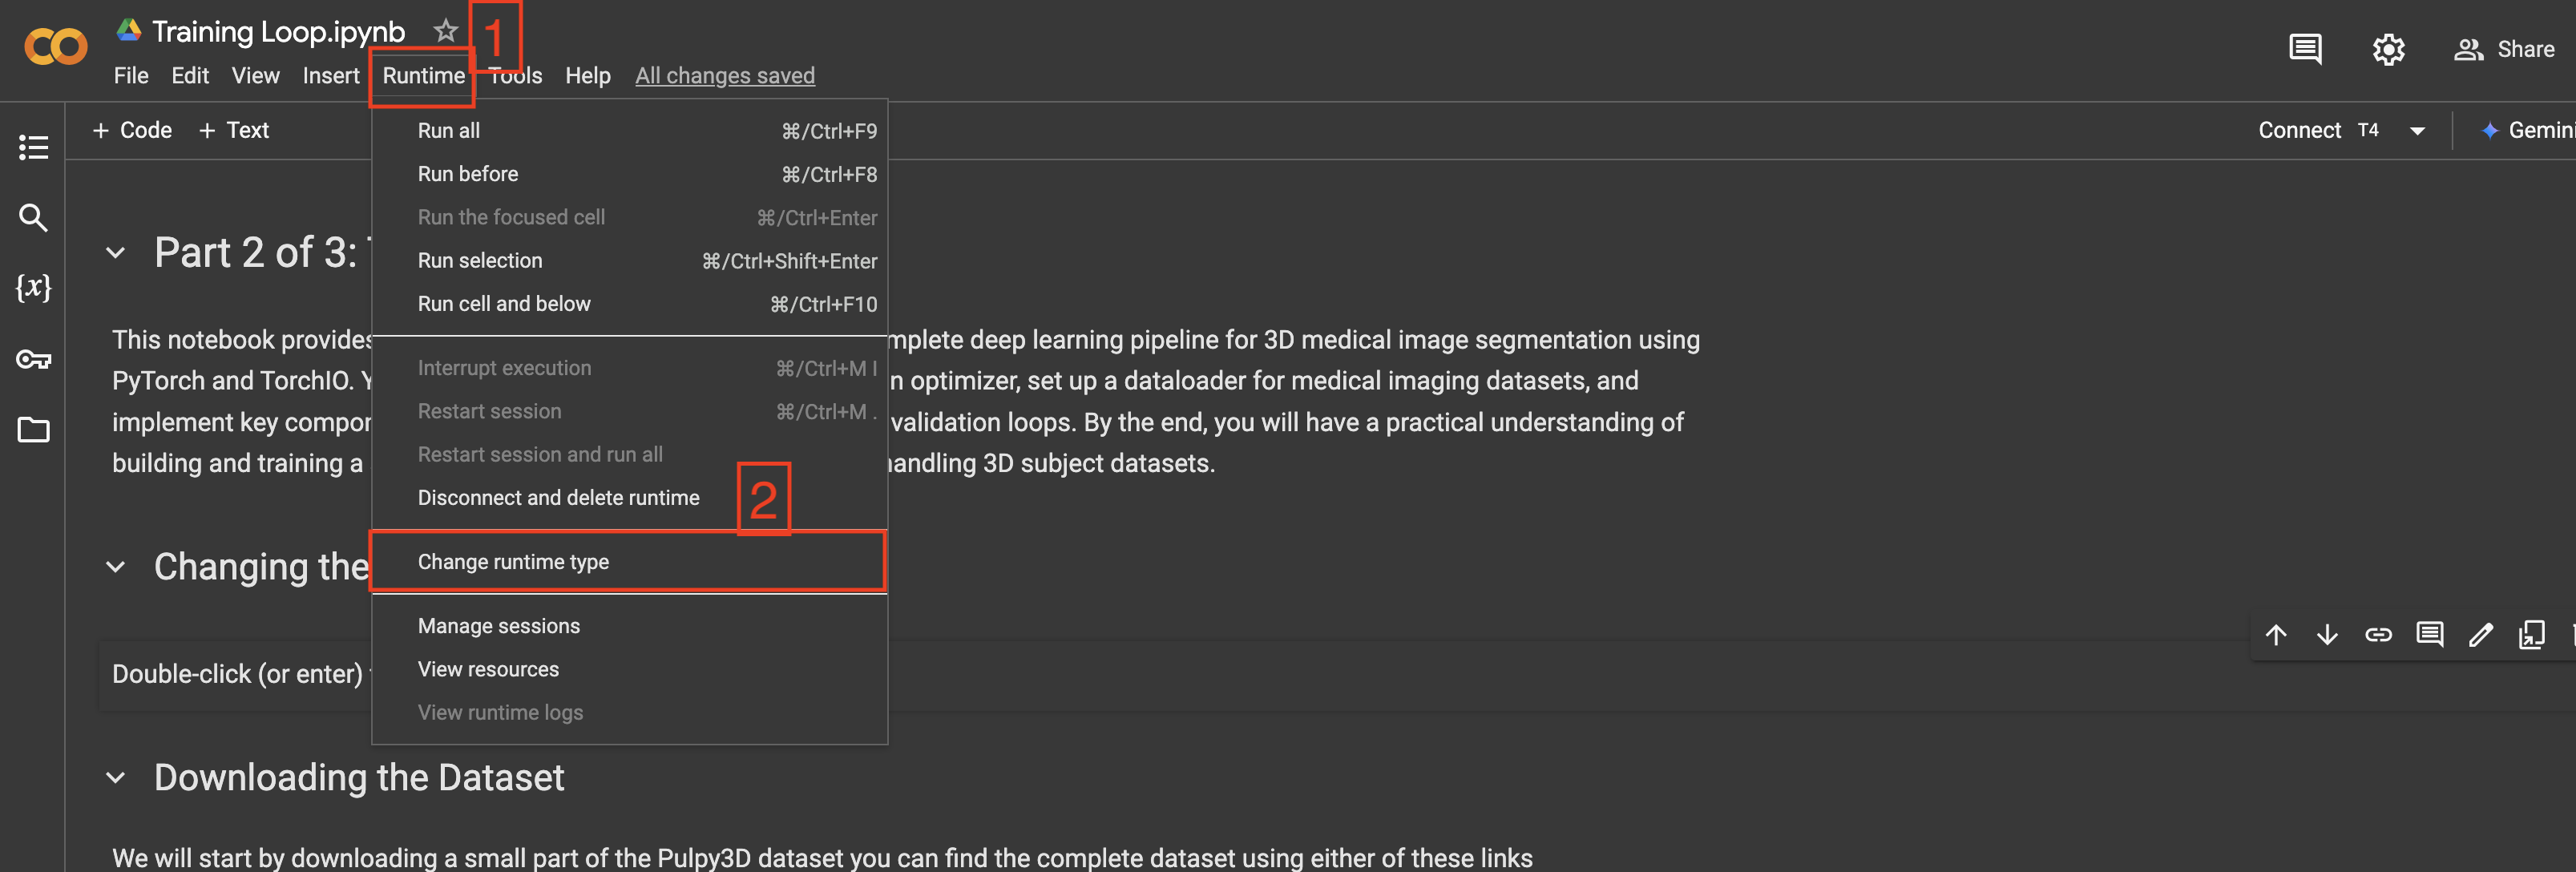

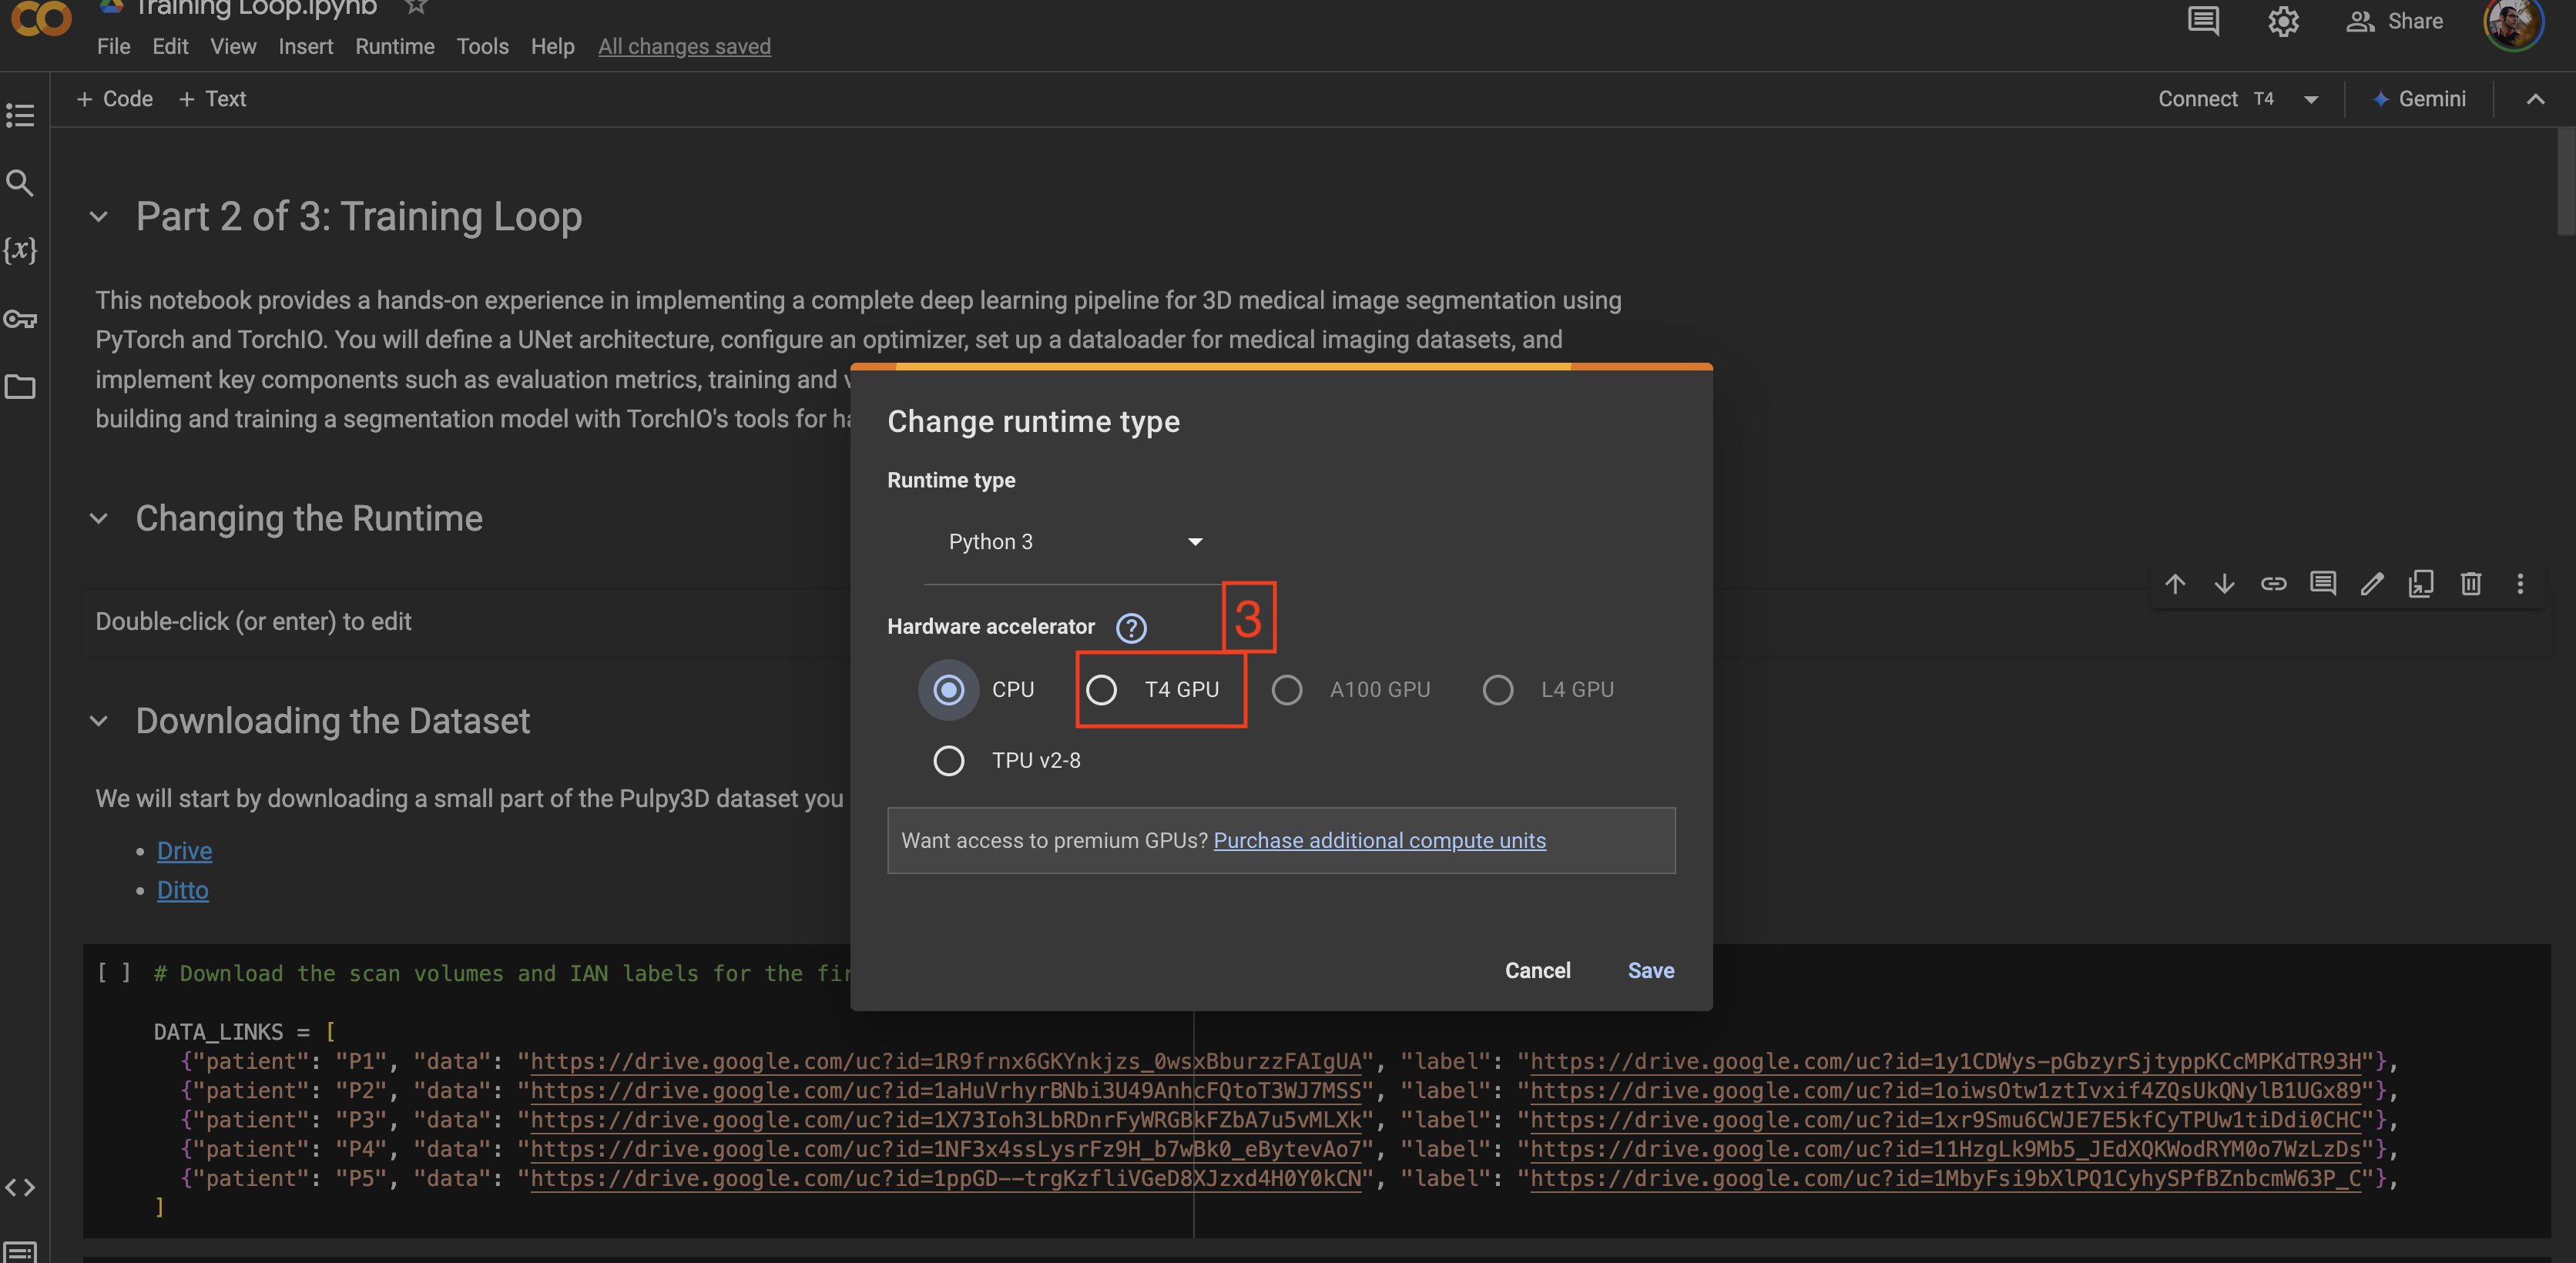

## Downloading the Dataset

We will start by downloading a small part of the Pulpy3D dataset you can find the complete dataset using either of these links

- [Drive](https://drive.google.com/drive/folders/1M5iU1urLOp1rSxKOm7WCzodAKcZrqT5O?usp=sharing)
- [Ditto](https://ditto.ing.unimore.it/pulpy3d/)

In [ ]:
# Download the scan volumes and IAN labels for the first 5 patients

DATA_LINKS = [
	{"patient": "P1", "data": "https://drive.google.com/uc?id=1R9frnx6GKYnkjzs_0wsxBburzzFAIgUA", "label": "https://drive.google.com/uc?id=1y1CDWys-pGbzyrSjtyppKCcMPKdTR93H"},
	{"patient": "P2", "data": "https://drive.google.com/uc?id=1aHuVrhyrBNbi3U49AnhcFQtoT3WJ7MSS", "label": "https://drive.google.com/uc?id=1oiwsOtw1ztIvxif4ZQsUkQNylB1UGx89"},
	{"patient": "P3", "data": "https://drive.google.com/uc?id=1X73Ioh3LbRDnrFyWRGBkFZbA7u5vMLXk", "label": "https://drive.google.com/uc?id=1xr9Smu6CWJE7E5kfCyTPUw1tiDdi0CHC"},
	{"patient": "P4", "data": "https://drive.google.com/uc?id=1NF3x4ssLysrFz9H_b7wBk0_eBytevAo7", "label": "https://drive.google.com/uc?id=11HzgLk9Mb5_JEdXQKWodRYM0o7WzLzDs"},
	{"patient": "P5", "data": "https://drive.google.com/uc?id=1ppGD--trgKzfliVGeD8XJzxd4H0Y0kCN", "label": "https://drive.google.com/uc?id=1MbyFsi9bXlPQ1CyhySPfBZnbcmW63P_C"},
]

In [ ]:
import os
import gdown

# Create the dataset directory
os.makedirs('data', exist_ok=True)

# Download each patient
for entry in DATA_LINKS:
  # Create the patient directory that will hold
  # the data and label files
  patient_path = os.path.join('data', entry['patient'])
  os.makedirs(patient_path, exist_ok=True)

  # Specify data and label output file name
  data_output = os.path.join(patient_path, 'data.nii.gz')
  label_output = os.path.join(patient_path, 'label.nii.gz')

  # Download the files
  gdown.download(entry['data'], data_output, quiet=False)
  gdown.download(entry['label'], label_output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1R9frnx6GKYnkjzs_0wsxBburzzFAIgUA
From (redirected): https://drive.google.com/uc?id=1R9frnx6GKYnkjzs_0wsxBburzzFAIgUA&confirm=t&uuid=c8adda14-cdaf-4466-98b2-4e79f4773ac5
To: /content/data/P1/data.nii.gz
100%|██████████| 55.8M/55.8M [00:00<00:00, 193MB/s]
Downloading...
From: https://drive.google.com/uc?id=1y1CDWys-pGbzyrSjtyppKCcMPKdTR93H
To: /content/data/P1/label.nii.gz
100%|██████████| 799k/799k [00:00<00:00, 42.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1aHuVrhyrBNbi3U49AnhcFQtoT3WJ7MSS
From (redirected): https://drive.google.com/uc?id=1aHuVrhyrBNbi3U49AnhcFQtoT3WJ7MSS&confirm=t&uuid=8230abd0-365c-4370-ad73-9ccd2fe85bb3
To: /content/data/P2/data.nii.gz
100%|██████████| 49.4M/49.4M [00:02<00:00, 20.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oiwsOtw1ztIvxif4ZQsUkQNylB1UGx89
To: /content/data/P2/label.nii.gz
100%|██████████| 723k/723k [00:00<00:00, 140MB/s]
Downloading...
From (o

# Installing Dependencies

In [ ]:
!pip install torchio==0.19.1 SimpleITK==2.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.8/172.8 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 12.9 MB/s eta 0:00:00


# Creating the Loop

### Creating the Model Layers

We will create a UNET but for 3D image inputs which utilizes 3D convolutions

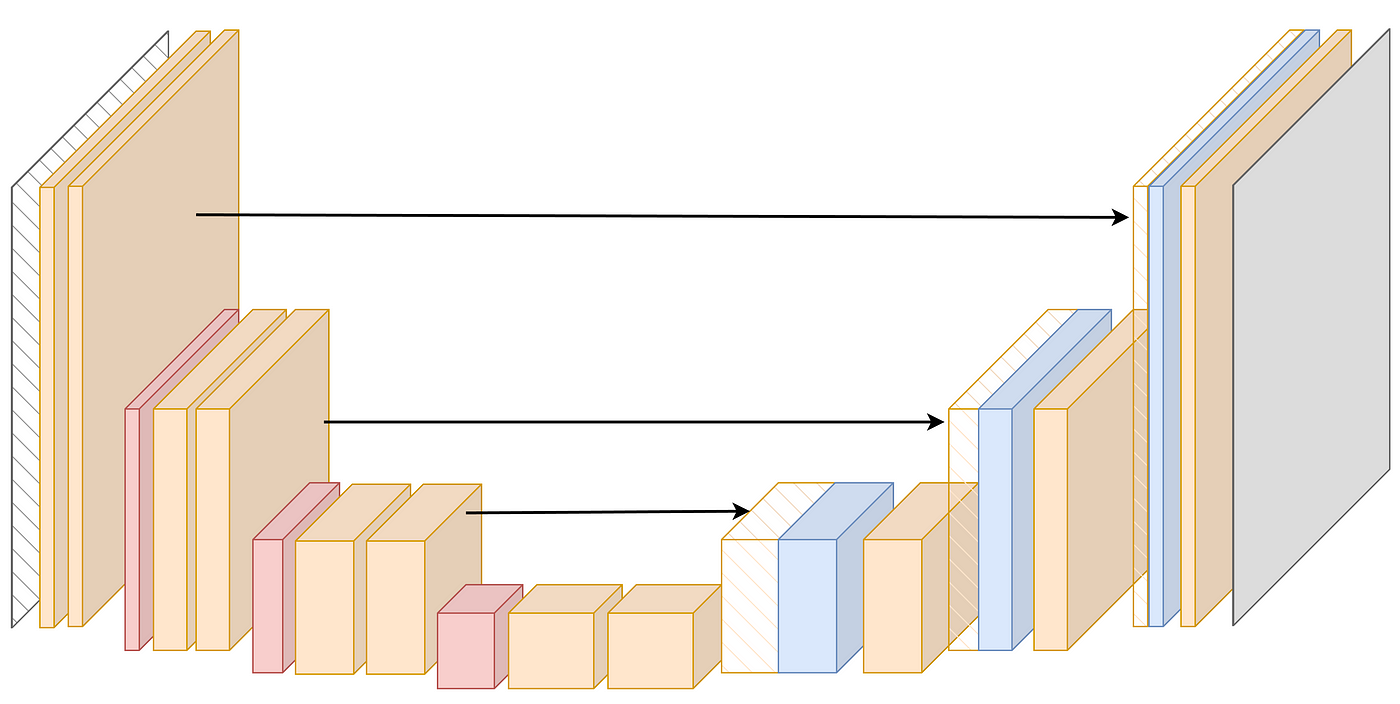

In [ ]:
import torch.nn as nn
from collections import OrderedDict
import torch


class UNet3D(nn.Module):
    """
    UNet3D implementation
    """

    def __init__(self, in_channels, out_channels, init_features=16, image_shape=(80,80,80)):
        super(UNet3D, self).__init__()
        self.features = init_features
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.emb_shape = torch.as_tensor([int(x / init_features) for x in image_shape])

        # Embedding Layer
        self.pos_emb_layer = nn.Linear(6, torch.prod(self.emb_shape).item())

        # Encoding Branch
        self.encoder1 = UNet3D._block(self.in_channels, self.features, name="enc1")
        self.encoder2 = UNet3D._block(self.features, self.features * 2, name="enc2")
        self.encoder3 = UNet3D._block(self.features * 2, self.features * 4, name="enc3")
        self.encoder4 = UNet3D._block(self.features * 4, self.features * 8, name="enc4")

        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2)
        self.pool4 = nn.MaxPool3d(kernel_size=2, stride=2)


        # Bottlenneck
        self.bottleneck = UNet3D._block(self.features * 8, self.features * 16, name="bottleneck")

        # Decoding Branch
        self.upconv4 = nn.ConvTranspose3d(self.features * 16 + 1, self.features * 8, kernel_size=2, stride=2)
        self.upconv3 = nn.ConvTranspose3d(self.features * 8, self.features * 4, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose3d(self.features * 4, self.features * 2, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose3d(self.features * 2, self.features, kernel_size=2, stride=2)
        self.decoder4 = UNet3D._block((self.features * 8) * 2, self.features * 8, name="dec4")
        self.decoder3 = UNet3D._block((self.features * 4) * 2, self.features * 4, name="dec3")
        self.decoder2 = UNet3D._block((self.features * 2) * 2, self.features * 2, name="dec2")
        self.decoder1 = UNet3D._block(self.features * 2, self.features, name="dec1")

        # Output Layer
        self.conv = nn.Conv3d(in_channels=self.features, out_channels=self.out_channels, kernel_size=1)

    def forward(self, x, emb_codes):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        emb_pos = self.pos_emb_layer(emb_codes).view(-1, 1, *self.emb_shape)
        bottleneck = torch.cat((bottleneck, emb_pos), dim=1)

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        output = self.conv(dec1)

        return output

    @staticmethod
    def _block(in_channels, features, name, prob=0.2):
        block = nn.Sequential(OrderedDict([
            (name + "conv1", nn.Conv3d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False, ),),
            (name + "norm1", nn.GroupNorm(num_groups=8, num_channels=features)),
            (name + "droupout1", nn.Dropout3d(p=prob, inplace=True)),
            (name + "relu1", nn.ReLU(inplace=True)),
            (name + "conv2", nn.Conv3d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False, ),),
            (name + "norm2", nn.GroupNorm(num_groups=8, num_channels=features)),
            (name + "droupout2", nn.Dropout3d(p=prob, inplace=True)),
            (name + "relu2", nn.ReLU(inplace=True)),
        ]))
        return block

### Creating the Dataset

We will create a dataset of Subjects (3D volumes) on which the model will train on

In [ ]:
import os
import torchio as tio

class Dataset(tio.SubjectsDataset):
  def __init__(self, root, patients, transform=None, **kwargs):
    subjects_list = self._get_subjects_list(root, patients)
    super().__init__(subjects_list, transform, **kwargs)

  def _get_subjects_list(self, root, patients):
    subjects = []
    for patient in patients:
      data_path = os.path.join(root, patient, 'data.nii.gz')
      if not os.path.isfile(data_path):
        raise ValueError(f'Missing data file for patient {patient} ({data_path})')

      label_path = os.path.join(root, patient, 'label.nii.gz')
      if not os.path.isfile(label_path):
        raise ValueError(f'Missing gt file for patient {patient} ({label_path})')

      subject_dict = {
        'patient': patient,
        'data': tio.ScalarImage(data_path),
        'label': tio.LabelMap(label_path)
      }

      subjects.append(tio.Subject(**subject_dict))
    print(f"Loaded {len(subjects)} patients")
    return subjects

### Creating the Evaluator

In [ ]:
import torch
import torch.nn.functional as F
from statistics import mean

# Small value to avoid zero division
epsilon = torch.finfo(torch.float64).eps

class Evaluator:
  def __init__(self):
    self.dice_list = []

  def reset_eval(self):
    self.dice_list.clear()


  def compute_dice(self, pred, gt):
    pred = torch.sum(pred == 1, dim=list(range(1, pred.ndim)))
    gt = torch.sum(gt == 1, dim=list(range(1, gt.ndim)))

    intersection = (pred & gt).sum()
    dice_union = pred.sum() + gt.sum()

    dice = (2 * intersection + epsilon) / (dice_union + epsilon)

    self.dice_list.append(dice.item())

  def mean_metric(self):
    dice = 0 if len(self.dice_list) == 0 else mean(self.dice_list)
    self.reset_eval()
    return dice

### Augmentations and Preprocessing

In [ ]:
import torchio as tio

# Preprocessing
preprocessing = tio.Compose([
    tio.Clamp(0, 2100),
    tio.RescaleIntensity((0, 1))
])

# Augmentations
augmentations = tio.Compose([
    tio.RandomAffine(scales=(0.8, 1.2), degrees=(15, 15), p=0.35),
    tio.RandomBlur(p=0.25),
    tio.RandomSwap(patch_size=15)
])

transforms = tio.Compose([preprocessing, augmentations])

### Dataloader
The dataloader is the interface used by the model to feed it the required subjects to train on. At this point any transformations / augmentations / preprocessing are done on the data

Most of the configurations reside here:
- 3D volume patch shape
- Queue Length
- Samples to be taken from each volume
- Number of workers
- Batch Size

In [ ]:
import torchio as tio
from torch.utils.data import DataLoader

data_path = "./data"
configs = {
  'patch_shape': 64,
  'max_length': 30,
  'samples_per_volume': 10,
  'num_workers': 2,
  'batch_size': 8
}
splits = {
    "train": ["P1", "P2", "P3"],
    "test": ["P4", "P5"]
}

# Train Loader
train_dataset = Dataset(data_path, splits['train'], transform=transforms)
train_sampler = tio.LabelSampler(patch_size=configs['patch_shape'], label_name='label', label_probabilities={0: 1, 1: 4})
train_queue = tio.Queue(
  subjects_dataset=train_dataset,
  max_length=configs['max_length'],
  samples_per_volume=configs['samples_per_volume'],
  sampler=train_sampler,
  num_workers=configs['num_workers'],
  shuffle_subjects=True,
  shuffle_patches=True,
  start_background=True,
)

train_loader = DataLoader(train_queue, batch_size=configs['batch_size'], num_workers=0, pin_memory=False, drop_last=False)

Loaded 3 patients


### Initializing the Model

In [ ]:
import torch.nn as nn
import torch
from torch.optim import Adam

torch.manual_seed(42)

image_shape = tuple([configs['patch_shape']] * 3)
model = UNet3D(in_channels=1, out_channels=1, image_shape=image_shape).cuda()

optimizer = Adam(model.parameters(), lr=0.001)
loss = nn.BCEWithLogitsLoss()

evaluator = Evaluator()

### Train Loop

In [ ]:
import torch

# Small value to avoid zero division
epsilon = torch.finfo(torch.float64).eps

# Utility to extract images and labels from loaded volume patch
def extract_data_from_patch(patch):
    images = patch['data'][tio.DATA].float().cuda()
    gt = patch['label'][tio.DATA].float().cuda()
    emb_codes = torch.cat((
      patch[tio.LOCATION][:,:3],
      patch[tio.LOCATION][:,:3] + torch.as_tensor(images.shape[-3:])
    ), dim=1).float().cuda()

    return images, gt, emb_codes

model.train()
evaluator.reset_eval()

losses = []

for batch in train_loader:
  images, gt, emb_codes = extract_data_from_patch(batch)
  partition_weights = 1

  # Skip empty volumes
  gt_count = torch.sum(gt == 1, dim=list(range(1, gt.ndim)))
  if torch.sum(gt_count) == 0: continue
  partition_weights = (epsilon + gt_count) / torch.max(gt_count)
  optimizer.zero_grad()

  preds = model(images, emb_codes)
  assert preds.ndim == gt.ndim, f'Gt and output dimensions are not the same before loss. {preds.ndim} vs {gt.ndim}'

  loss_val = (loss(preds, gt) * partition_weights).mean()
  losses.append(loss_val.item())
  loss_val.backward()

  optimizer.step()

  # Transform sigmoid scale to segmentation map
  preds = torch.sigmoid(preds)
  preds = (preds > 0.5)

  evaluator.compute_dice(preds, gt)

epoch_train_loss = sum(losses) / len(losses) if len(losses) > 0 else 0
epoch_train_dice = evaluator.mean_metric()

print(f'Epoch Loss: {epoch_train_loss}')
print(f'Epoch Dice: {epoch_train_dice}')


Epoch Loss: 0.38671157509088516
Epoch Dice: 0.0598595158662647


### Test Loop

In [ ]:
import torch
import torchio as tio
from torch.utils.data import DataLoader


model.eval()
with torch.inference_mode():
  evaluator.reset_eval()
  losses = []

  dataset = Dataset(data_path, splits['test'], transform=preprocessing)

  for subject in dataset:
    sampler = tio.inference.GridSampler(
      subject,
      configs['patch_shape'],
      0
    )

    loader = DataLoader(sampler, batch_size=configs['batch_size'])
    aggregator = tio.inference.GridAggregator(sampler)
    gt_aggregator = tio.inference.GridAggregator(sampler)

    for patch in loader:
      images, gt, emb_codes = extract_data_from_patch(patch)

      preds = model(images, emb_codes)
      aggregator.add_batch(preds, patch[tio.LOCATION])
      gt_aggregator.add_batch(gt, patch[tio.LOCATION])

    output = aggregator.get_output_tensor()
    gt = gt_aggregator.get_output_tensor()
    partition_weights = 1

    gt_count = torch.sum(gt == 1, dim=list(range(1, gt.ndim)))
    if torch.sum(gt_count) != 0:
      partition_weights = (epsilon + gt_count) / (epsilon + torch.max(gt_count))

    loss_val = (loss(output.unsqueeze(0), gt.unsqueeze(0)) * partition_weights).mean()
    losses.append(loss_val.item())

    output = output.squeeze(0)
    output = torch.sigmoid(output)
    output = (output > 0.5)

    evaluator.compute_dice(output.unsqueeze(0), gt.unsqueeze(0))

  epoch_test_loss = sum(losses) / len(losses)
  epoch_test_dice = evaluator.mean_metric()

  print(f'Epoch Loss: {epoch_test_loss}')
  print(f'Epoch Dice: {epoch_test_dice}')

Loaded 2 patients
Epoch Loss: 0.5217417478561401
Epoch Dice: 0.8172464072704315
